# Modeling Bitcoin's Price with Metcalfe's Law

Modeling Bitcoin's fundemantal value with Metcalfe's law.


## Intro

According to [Metcalfe's Law](https://en.wikipedia.org/wiki/Metcalfe%27s_law) the  value of a network ([fully deluted market cap](https://capital.com/fully-diluted-market-capitalisation-in-cryptocurrency-definition)) is proportinal to the number of possible connection between their participants (wallets). As each partcipant can have $n-1$ connection, the value of the network ($V$), is 

$$ V = A \frac{n (n-1)}{2} $$

$A$, the affinity is constant, denoting the value of one (possible) conection between two network participants. 

This notebook calculates the value of Bitcoin network (V), based on the number of wallets holding at least a minimum amount of BTCs ($n_{m\leq}$). 

The straighforward and easy way of telling the value of any blockchain is to calcutate its [fully deluted market cap](https://capital.com/fully-diluted-market-capitalisation-in-cryptocurrency-definition) (FDMC). However, it has obvoius problems. FDMC is based on a highly volatile current market price, and very much subject to booms and busts of market cycles. It has no substance, and has no predictive power. The elagance of the [Metcalfe's Law](https://en.wikipedia.org/wiki/Metcalfe%27s_law) is, that once we have calibrated $A$, it can give a more grounded market value.

As $n$ is large in our case, we can shamelessly simplify our Metcalfe formula as  
$$ V = A \frac{n_{m\leq}^2}{2} $$ where 
- $V$ is the Value of the network 
- $n_{m\leq}$ denotes to the number of BTC addresses (_addresses_) holding at least $m$ bitcoins (as given in variable _wallet_ranges_ later on) and 
- $A$, is the affinity, a constant value the value of potential transaction between two wallets. An other way of putting it, for every new wallet appearing on the network with over $m$ BTCs, each wallet above $m$ BTC gains $\frac{A}{2}$ in value on average. 

As wallets can be created cheaply and algorthmically we only consider non-empty wallets. 

Our challenge is to find $A_{min}$ and $A_{max}$ values for each _wallet_ranges_ elements, and then to calculate the minumum and maximum BTC prices from $A_{min}$ and $A_{max}$.

$$ V_{A_{min}} \leq V_{FDMC} \leq V_{A_{max}} $$

Let $S$ be the maximum supply of of Bitcoin wich is 21 million, and $P(t)$ be the price of BTC at the time of t. As $n$ is also a function of time we can conclude that 
$$ A_{min} \frac{n_{m\leq}^2(t)}{2} \leq S P(t) \leq \frac{A_{max} n_{m\leq}^2(t)}{2} $$
$$ A_{min}  \leq \frac{2 S P(t)}{n_{m\leq}^2(t)} \leq A_{max} $$
for any $t$ point in time.

Once we calibarated the value of $A_{min}$ and $A_{max}$ for a certain $m$, we can safely assume that in any future time 

$$ 
A_{min} \leq A(t) = \frac{ 2 S P(t)}{n_{m\leq}^2(t)} \leq A_{max} 
$$


if we are more focused on minimum and maximum BTC price ranges 
$$
P_{min}(t) = A_{min} \frac{ n_{m\leq}^2(t) }{2 S}  \leq P(t) \leq P_{max}(t) = A_{max} \frac{ n_{m\leq}^2(t) }{2 S} 
$$
Later we also give try to extrapolate the growth of wallet holders, thus estimating the future price of BTC.

## Input Parameters

In [1]:
data_fetch_start_date = '2010-01-01'
plot_start_date = '2010-09-01'
plot_start_date_extrapolation = '2014-01-01'
affinity_calibration_start_date = '2017-01-01'


# Having more or same amount of BTC as [x,y,z]
# You can choose from  =  ['1000+', '100+', '10+', '1+', '0.1+', '0.01+', '0.001+','1e-08+']
#wallet_ranges =  ['1000+', '100+', '10+', '1+', '0.1+', '0.01+', '0.001+','1e-08+']
#wallet_ranges = ['1e-08+', '0.001+','0.1+', '0.01+']
wallet_ranges = ['1e-08+','0.001+']

# Reuqested Simple Moving Averages for calucating A (affinity)
smas = [7,30,90,180,365,720,1300]
ranges_from_sma_days = 30

# Due to the growth of USD supply, the value  1 USD changes over time, spoiling our BTC/USD price. The circumvent this,  
# we need find a date where baseline our prices to. 
# The default is to baseline all BTC price to today's USD dollar,leaving usd_baseline_date undefined. 

#usd_baseline_date = pd.to_datetime('2009-01-03') # Birthday of BTC

linear_fitting_start_date='2016-01-01'
extrapolation_end_date ='2034-01-01'


# cryptocompare.com API Key for fetching BTC wallet distributions and price 
# Get your own fee API key at https://min-api.cryptocompare.com/pricing
cryptocompare_api_key = ''

# https://fred.stlouisfed.org/ 
# Get your own fee API key at https://fred.stlouisfed.org/docs/api/api_key.html
fred_api_key = ''


## Fetching & Cleaning Data  

### Fetching BTC Price History


We use [CryptoCompare API](https://min-api.cryptocompare.com/documentation) to fetch the th historical BTC prices in USD, and the wallet chohorts grouped by the min to max BTC ranges.

In [2]:
import requests
import json
import pandas as pd
pd.options.mode.chained_assignment = None  # default='warn'
from datetime import date
import time
requestUrls = ['https://min-api.cryptocompare.com/data/blockchain/balancedistribution/histo/day?fsym={}&api_key={}&toTs={}&limit={}',
              'https://min-api.cryptocompare.com/data/v2/histoday?fsym={}&tsym=USD&api_key={}&toTs={}&limit={}']

# cryptocompare.com API Key for fetching BTC wallet distributions and price 
# Get your own fee API key at https://min-api.cryptocompare.com/pricing
cryptocompare_api_key = cryptocompare_api_key or '777db0605f662ba6667a0c8d385d317262bd221764d4a3b01dc7a629e9592a49'
limit=2000
coins=['BTC']  # Only BTC is available at cryptocompare
coin = coins[0] # 'BTC'

data_fetch_start_date_ts = pd.Timestamp(data_fetch_start_date)
coin_dfs=[]
range_names=[]

for coin in coins:
    time_segments = []
    timestamp = pd.Timestamp.now()
    while data_fetch_start_date_ts <= timestamp : 
        segment_dfs = []
        for requestUrl in requestUrls:
            segment_df = pd.DataFrame()
            requestUrl = requestUrl.format(coin, cryptocompare_api_key, timestamp.timestamp(),limit)
            # print("Request : " + requestUrl)    
            response = requests.get(requestUrl).text 
            parsed = json.loads(response)
            # print("Json : \n\n" + response)
            segment_df = pd.DataFrame(parsed['Data']['Data'])
            segment_df['time'] = pd.to_datetime(segment_df['time'], unit='s')
            segment_df.set_index(['time'],inplace=True, verify_integrity = True, drop = True)
            segment_df.sort_index(inplace=True)
            segment_dfs.append(segment_df)
        
        #segment_df.drop_duplicates(inplace=True)
        concated_segment_dfs= pd.concat(segment_dfs,axis=1)
        time_segments.append(concated_segment_dfs) 
        
        timestamp = segment_df.first_valid_index() - pd.Timedelta(1, "d") # -1 day    
        concated_segment_dfs.drop(columns=['volumefrom','volumeto','conversionType'
                                           ,'conversionSymbol', 'open','high','low'
                                           ,'id','symbol','partner_symbol'], inplace=True)
        #print("seg tail {}".format(concated_segment_dfs.tail(1)))

    df = pd.concat(time_segments, axis=0)
    df.sort_index(inplace=True)
    # print("Df {}\n".format(df))    
    df.dropna(inplace=True)
    df_wallet_ranges = [] 
    for i in range(10):
        df_wallet_range = pd.DataFrame()
        df_wallet_range['addresses'] = df['balance_distribution'].map(lambda x: x[i]['addressesCount'])
         # df_wallet_range['totalVolume'] = df['balance_distribution'].map(lambda x: x[i]['totalVolume'])
        vindex= df.first_valid_index()  
        range_name = "{}:{}".format(df.loc[vindex,['balance_distribution']][0][i]['from'], 
                                    df.loc[vindex,['balance_distribution']][0][i]['to'])
        range_names.append(range_name)
        df_wallet_range =  pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
        df_wallet_ranges.append(df_wallet_range)
    range_name = "USD" 
    df_wallet_range = pd.DataFrame()
    df_wallet_range['price'] = df['close']
    df_wallet_range = pd.concat({range_name: df_wallet_range}, axis=1, names=["wallet_range", "metrics"]) 
    df_wallet_ranges.append(df_wallet_range)
    
    df = pd.concat(df_wallet_ranges, axis=1)
 
    df = pd.concat({coin: df}, axis=1, names=["coin", "wallet_range", "metrics"])
    coin_dfs.append(df)
df=pd.concat(coin_dfs, axis=1)
df=df.loc[data_fetch_start_date_ts:]
df.sort_index(inplace=True)
df

coin                 BTC                                                     \
wallet_range 1e-08:0.001 0.001:0.01  0.01:0.1     0.1:1      1:10    10:100   
metrics        addresses  addresses addresses addresses addresses addresses   
time                                                                          
2010-01-01             0          0         6         3        10     29905   
2010-01-02             0          0         6         3        10     30031   
2010-01-03             0          0         6         3        10     30217   
2010-01-04             0          0         6         3        10     30318   
2010-01-05             0          0         6         3        10     30516   
...                  ...        ...       ...       ...       ...       ...   
2023-12-29      27492338   12307574   8168094   3560100    868598    139436   
2023-12-30      27545865   12297814   8171586   3558961    868527    139443   
2023-12-31      27595665   12330066   8180732   3560923    868769    139362   
2024-01-01      27601196   12320919   8176651   3561831    869103    139446   
2024-01-02      27575524   12277692   8166021   3560215    868646    139387   

coin                                                                     
wallet_range  100:1000 1000:10000 10000:100000 100000:1000000       USD  
metrics      addresses  addresses    addresses      addresses     price  
time                                                                     
2010-01-01          26          5            4              0      0.00  
2010-01-02          26          5            4              0      0.00  
2010-01-03          26          5            4              0      0.00  
2010-01-04          26          5            4              0      0.00  
2010-01-05          26          5            4              0      0.00  
...                ...        ...          ...            ...       ...  
2023-12-29       13964       1925          104              4  42073.59  
2023-12-30       13924       1924          103              4  42146.03  
2023-12-31       13909       1920          102              4  42280.14  
2024-01-01       13909       1919          103              4  44197.61  
2024-01-02       13903       1922          103              4  44970.34  

[5115 rows x 11 columns]

### Wallet Range Conversion

Instead of wallet ranges bounded on both sides, we need the number wallets have a mininum number of BTCs or more, __without upper limit__. 

In [3]:
df_aux = pd.DataFrame()
aggregate_wallets=[]
open_end_range_name = []
for range_name in reversed(range_names):
    open_end_range_name = range_name[:range_name.rindex(':')] + '+';
    aggregate_wallets.append(range_name)
    addressCounts = [df[coin][w_range]['addresses'] for w_range in aggregate_wallets]
    df_aux['addresses'] = sum(addressCounts)
    if open_end_range_name in wallet_ranges:
        df.loc(axis=1)[(coin,open_end_range_name ,'addresses')] = df_aux['addresses']
df.drop(columns=[*range_names],inplace=True,level= "wallet_range")


df

coin               BTC                    
wallet_range       USD    0.001+    1e-08+
metrics          price addresses addresses
time                                      
2010-01-01        0.00     29959     29959
2010-01-02        0.00     30085     30085
2010-01-03        0.00     30271     30271
2010-01-04        0.00     30372     30372
2010-01-05        0.00     30570     30570
...                ...       ...       ...
2023-12-29    42073.59  25059799  52552137
2023-12-30    42146.03  25052286  52598151
2023-12-31    42280.14  25095787  52691452
2024-01-01    44197.61  25083885  52685081
2024-01-02    44970.34  25027893  52603417

[5115 rows x 3 columns]

### Fetching M2 Monetary Supply

The purchasing power of $1 today is lot less then it was few years back or even a deceade ago. Therefore, we need to adjust the past BTC price to current dollar value. This happens by revaluing the original price of bitcoin so that it is proprtional to [M2 monetary supply](https://en.wikipedia.org/wiki/Money_supply) increase of US dollar. We fetch the [M2NS series](https://fred.stlouisfed.org/series/M2NS) from [FED's FRED API](https://fred.stlouisfed.org/docs/api/fred/) for the montly M2 monetary supply.

In [4]:



# https://fred.stlouisfed.org/series/M2SL
fredRequestTemplate = 'https://api.stlouisfed.org/fred/series/observations?series_id=M2NS&api_key={}&file_type=json&observation_start=2008-01-01&frequency=m'

# https://fred.stlouisfed.org/ 
# Get your own fee API key at https://fred.stlouisfed.org/docs/api/api_key.html

fred_api_key = fred_api_key or 'b121cc395b21e22273f7275e8c49a2d0'
requestUrl = fredRequestTemplate.format(fred_api_key)

#print("Request : " + requestUrl)    
response = requests.get(requestUrl).text 
parsed = json.loads(response)
#print("Json : \n\n" + response)
df_m2 = pd.DataFrame(parsed['observations'])
df_m2['date'] = pd.to_datetime(df_m2['date'], yearfirst=True,format='ISO8601')
df_m2['m2_supply'] = pd.to_numeric(df_m2['value'], errors='coerce')
df_m2.set_index(['date'],inplace=True, verify_integrity = True, drop = True)
df_m2.sort_index(inplace=True)
df_m2.drop(columns=['realtime_start','realtime_end','value'], inplace=True)
df_m2



,m2_supply
date,
2008-01-01,7502.6
2008-02-01,7585.2
2008-03-01,7719.2
2008-04-01,7767.6
2008-05-01,7709.1
...,...
2023-07-01,20745.3
2023-08-01,20721.2
2023-09-01,20699.7


### Adjust BTC Price with M2 Monetary Supply

In [5]:
def convert_to_m2(df,dt):
    iloc_idx = df.index.get_indexer([dt], method='nearest') 
    loc_idx = df.index[iloc_idx]                        
    return df.loc[loc_idx,'m2_supply'].values[0] 

df.loc(axis=1)[('USD','all', 'm2_supply')] = df.index.map(lambda dt: convert_to_m2(df_m2,dt))
df

coin               BTC                           USD
wallet_range       USD    0.001+    1e-08+       all
metrics          price addresses addresses m2_supply
time                                                
2010-01-01        0.00     29959     29959    8464.4
2010-01-02        0.00     30085     30085    8464.4
2010-01-03        0.00     30271     30271    8464.4
2010-01-04        0.00     30372     30372    8464.4
2010-01-05        0.00     30570     30570    8464.4
...                ...       ...       ...       ...
2023-12-29    42073.59  25059799  52552137   20760.2
2023-12-30    42146.03  25052286  52598151   20760.2
2023-12-31    42280.14  25095787  52691452   20760.2
2024-01-01    44197.61  25083885  52685081   20760.2
2024-01-02    44970.34  25027893  52603417   20760.2

[5115 rows x 4 columns]

In [6]:
# Due to growth of USD supply the value  1 USD changes over time, therefore we need find a date where baseline our prices to. 
# The deault is to baseline all BTC price to today's USD dollar 

last_day = df_m2[df_m2['m2_supply'] >0 ].index.max() # The last date of our BTC time series
usd_baseline_date = locals().get("usd_baseline_date", last_day)
#usd_baseline_date = pd.to_datetime('2009-01-03') # Birthday of BTC
adj_usd_key= 'USD_' + str(usd_baseline_date.year)+'_' + str(usd_baseline_date.month)
m2_supply_at_baseline_date = convert_to_m2(df_m2, usd_baseline_date)
df.loc(axis=1)[('USD',adj_usd_key, 'm2_supply_index')] = df.loc(axis=1)[('USD','all', 'm2_supply')]/m2_supply_at_baseline_date
df.loc(axis=1)[(coin,adj_usd_key, 'price')] = df.loc(axis=1)[('BTC','USD', 'price')] /df.loc(axis=1)[('USD',adj_usd_key, 'm2_supply_index')]
df

coin               BTC                           USD                  \
wallet_range       USD    0.001+    1e-08+       all     USD_2023_11   
metrics          price addresses addresses m2_supply m2_supply_index   
time                                                                   
2010-01-01        0.00     29959     29959    8464.4        0.407722   
2010-01-02        0.00     30085     30085    8464.4        0.407722   
2010-01-03        0.00     30271     30271    8464.4        0.407722   
2010-01-04        0.00     30372     30372    8464.4        0.407722   
2010-01-05        0.00     30570     30570    8464.4        0.407722   
...                ...       ...       ...       ...             ...   
2023-12-29    42073.59  25059799  52552137   20760.2        1.000000   
2023-12-30    42146.03  25052286  52598151   20760.2        1.000000   
2023-12-31    42280.14  25095787  52691452   20760.2        1.000000   
2024-01-01    44197.61  25083885  52685081   20760.2        1.000000   
2024-01-02    44970.34  25027893  52603417   20760.2        1.000000   

coin                 BTC  
wallet_range USD_2023_11  
metrics            price  
time                      
2010-01-01          0.00  
2010-01-02          0.00  
2010-01-03          0.00  
2010-01-04          0.00  
2010-01-05          0.00  
...                  ...  
2023-12-29      42073.59  
2023-12-30      42146.03  
2023-12-31      42280.14  
2024-01-01      44197.61  
2024-01-02      44970.34  

[5115 rows x 6 columns]

## Affinity Calculation

We calcuate the M2 monetary supply-adjusted value of affinity $A_m(t)$ aka _df['BTC']['m+']['a']_ with following formula : 
$$ A_m'(t) = \frac{2 S P'(t)}{n_{m\leq}^2(t)} $$

In [7]:

btc_max_supply = 21*10**6
for min_btc in wallet_ranges:
    df.loc(axis=1)[(coin,min_btc,'a')] = 2*btc_max_supply*df.loc(axis=1)[(coin,adj_usd_key,'price')] \
        / ( df.loc(axis=1)[(coin, min_btc,'addresses')] \
        * df.loc(axis=1)[(coin, min_btc,'addresses')])
    for days in smas: 
        df.loc(axis=1)[(coin, min_btc, 'a_sma' + str(days) +'d')] = \
            df.loc(axis=1)[(coin, min_btc,'a')].rolling(days).mean()

# df=df.loc['2013-01-01':]
df

coin               BTC                           USD                  \
wallet_range       USD    0.001+    1e-08+       all     USD_2023_11   
metrics          price addresses addresses m2_supply m2_supply_index   
time                                                                   
2010-01-01        0.00     29959     29959    8464.4        0.407722   
2010-01-02        0.00     30085     30085    8464.4        0.407722   
2010-01-03        0.00     30271     30271    8464.4        0.407722   
2010-01-04        0.00     30372     30372    8464.4        0.407722   
2010-01-05        0.00     30570     30570    8464.4        0.407722   
...                ...       ...       ...       ...             ...   
2023-12-29    42073.59  25059799  52552137   20760.2        1.000000   
2023-12-30    42146.03  25052286  52598151   20760.2        1.000000   
2023-12-31    42280.14  25095787  52691452   20760.2        1.000000   
2024-01-01    44197.61  25083885  52685081   20760.2        1.000000   
2024-01-02    44970.34  25027893  52603417   20760.2        1.000000   

coin                 BTC                                          ...  \
wallet_range USD_2023_11    1e-08+                                ...   
metrics            price         a   a_sma7d  a_sma30d  a_sma90d  ...   
time                                                              ...   
2010-01-01          0.00  0.000000       NaN       NaN       NaN  ...   
2010-01-02          0.00  0.000000       NaN       NaN       NaN  ...   
2010-01-03          0.00  0.000000       NaN       NaN       NaN  ...   
2010-01-04          0.00  0.000000       NaN       NaN       NaN  ...   
2010-01-05          0.00  0.000000       NaN       NaN       NaN  ...   
...                  ...       ...       ...       ...       ...  ...   
2023-12-29      42073.59  0.000640  0.000657  0.000665  0.000598  ...   
2023-12-30      42146.03  0.000640  0.000652  0.000666  0.000599  ...   
2023-12-31      42280.14  0.000640  0.000649  0.000666  0.000601  ...   
2024-01-01      44197.61  0.000669  0.000650  0.000667  0.000603  ...   
2024-01-02      44970.34  0.000683  0.000654  0.000669  0.000605  ...   

coin                                                                       \
wallet_range                         0.001+                                 
metrics      a_sma720d a_sma1300d         a   a_sma7d  a_sma30d  a_sma90d   
time                                                                        
2010-01-01         NaN        NaN  0.000000       NaN       NaN       NaN   
2010-01-02         NaN        NaN  0.000000       NaN       NaN       NaN   
2010-01-03         NaN        NaN  0.000000       NaN       NaN       NaN   
2010-01-04         NaN        NaN  0.000000       NaN       NaN       NaN   
2010-01-05         NaN        NaN  0.000000       NaN       NaN       NaN   
...                ...        ...       ...       ...       ...       ...   
2023-12-29    0.000582   0.000820  0.002814  0.002880  0.002898  0.002595   
2023-12-30    0.000581   0.000820  0.002820  0.002864  0.002904  0.002603   
2023-12-31    0.000581   0.000820  0.002820  0.002854  0.002907  0.002611   
2024-01-01    0.000580   0.000820  0.002950  0.002858  0.002914  0.002621   
2024-01-02    0.000580   0.000821  0.003015  0.002882  0.002922  0.002631   

coin                                                   
wallet_range                                           
metrics      a_sma180d a_sma365d a_sma720d a_sma1300d  
time                                                   
2010-01-01         NaN       NaN       NaN        NaN  
2010-01-02         NaN       NaN       NaN        NaN  
2010-01-03         NaN       NaN       NaN        NaN  
2010-01-04         NaN       NaN       NaN        NaN  
2010-01-05         NaN       NaN       NaN        NaN  
...                ...       ...       ...        ...  
2023-12-29    0.002366  0.002229  0.002460   0.003403  
2023-12-30    0.002368  0.002233  0.002457   0.0034

### Calibrating $A_{min}$ and $A_{max}$

In [8]:
ranges_from_sma_days = ranges_from_sma_days or 30

for wallet_range in wallet_ranges:
    #wallet_range = str(min_btc) + '+'
    a_min = df[coin, wallet_range,'a_sma'+ str(ranges_from_sma_days)+ 'd'][affinity_calibration_start_date:].min()/btc_max_supply
    a_max = df[coin, wallet_range,'a_sma'+ str(ranges_from_sma_days)+ 'd'][affinity_calibration_start_date:].max()/btc_max_supply
    df.loc(axis=1)[(coin, wallet_range, 'a_min')] = a_min
#    df.loc(axis=1)[(coin, wallet_range, 'm2_adj_min_price')] = \
    df.loc(axis=1)[(coin, wallet_range, 'price_min_' + adj_usd_key)] = \
        a_min / 2  * df.loc(axis=1)[(coin,wallet_range,'addresses')]**2
#    df.loc(axis=1)[(coin, wallet_range, 'bottom_price')] = \
#        df.loc(axis=1)[(coin,wallet_range, 'm2_adj_min_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
    df.loc(axis=1)[(coin, wallet_range, 'a_max')] = a_max
    df.loc(axis=1)[(coin, wallet_range, 'price_max_' + adj_usd_key)] = \
        a_max / 2 * df.loc(axis=1)[(coin,wallet_range,'addresses')]**2
#    df.loc(axis=1)[(coin, wallet_range, 'top_price')] = \
#        df.loc(axis=1)[(coin,wallet_range, 'm2_adj_max_price')] * df.loc(axis=1)[('USD','all', 'm2_supply_index')]
    #print("k top-to-bottom ratio is {} at range {} using A_sma-{}d ".format(a_max/a_min,min_btc,ranges_from_sma_days ) )
    df= df.copy()
df

coin               BTC                           USD                  \
wallet_range       USD    0.001+    1e-08+       all     USD_2023_11   
metrics          price addresses addresses m2_supply m2_supply_index   
time                                                                   
2010-01-01        0.00     29959     29959    8464.4        0.407722   
2010-01-02        0.00     30085     30085    8464.4        0.407722   
2010-01-03        0.00     30271     30271    8464.4        0.407722   
2010-01-04        0.00     30372     30372    8464.4        0.407722   
2010-01-05        0.00     30570     30570    8464.4        0.407722   
...                ...       ...       ...       ...             ...   
2023-12-29    42073.59  25059799  52552137   20760.2        1.000000   
2023-12-30    42146.03  25052286  52598151   20760.2        1.000000   
2023-12-31    42280.14  25095787  52691452   20760.2        1.000000   
2024-01-01    44197.61  25083885  52685081   20760.2        1.000000   
2024-01-02    44970.34  25027893  52603417   20760.2        1.000000   

coin                 BTC                                          ...  \
wallet_range USD_2023_11    1e-08+                                ...   
metrics            price         a   a_sma7d  a_sma30d  a_sma90d  ...   
time                                                              ...   
2010-01-01          0.00  0.000000       NaN       NaN       NaN  ...   
2010-01-02          0.00  0.000000       NaN       NaN       NaN  ...   
2010-01-03          0.00  0.000000       NaN       NaN       NaN  ...   
2010-01-04          0.00  0.000000       NaN       NaN       NaN  ...   
2010-01-05          0.00  0.000000       NaN       NaN       NaN  ...   
...                  ...       ...       ...       ...       ...  ...   
2023-12-29      42073.59  0.000640  0.000657  0.000665  0.000598  ...   
2023-12-30      42146.03  0.000640  0.000652  0.000666  0.000599  ...   
2023-12-31      42280.14  0.000640  0.000649  0.000666  0.000601  ...   
2024-01-01      44197.61  0.000669  0.000650  0.000667  0.000603  ...   
2024-01-02      44970.34  0.000683  0.000654  0.000669  0.000605  ...   

coin                                                                   \
wallet_range    0.001+                   1e-08+                         
metrics      a_sma720d a_sma1300d         a_min price_min_USD_2023_11   
time                                                                    
2010-01-01         NaN        NaN  1.424951e-11              0.006395   
2010-01-02         NaN        NaN  1.424951e-11              0.006449   
2010-01-03         NaN        NaN  1.424951e-11              0.006529   
2010-01-04         NaN        NaN  1.424951e-11              0.006572   
2010-01-05         NaN        NaN  1.424951e-11              0.006658   
...                ...        ...           ...                   ...   
2023-12-29    0.002460   0.003403  1.424951e-11          19676.624692   
2023-12-30    0.002457   0.003404  1.424951e-11          19711.096994   
2023-12-31    0.002455   0.003405  1.424951e-11          19781.087902   
2024-01-01    0.002453   0.003406  1.424951e-11          19776.304671   
2024-01-02    0.002450   0.003407  1.424951e-11          19715.044047   

coin                                                            \
wallet_range                                            0.001+   
metrics              a_max price_max_USD_2023_11         a_min   
time                                                             
2010-01-01    8.508000e-11              0.038181  6.391041e-11   
2010-01-02    8.508000e-11              0.038503  6.391041e-11   
2010-01-03    8.508000e-11              0.038981  6.391041e-11   
2010-01-04    8.508000e-11              0.039241  6.391041e-11   
2010-01-05    8.508000e-11              0.039755  6.391041e-11   
...                    ...                   ...           ...   
2023-12-29    8.508000e-11         117483.872896  6.391041e-11   
2

### Plot

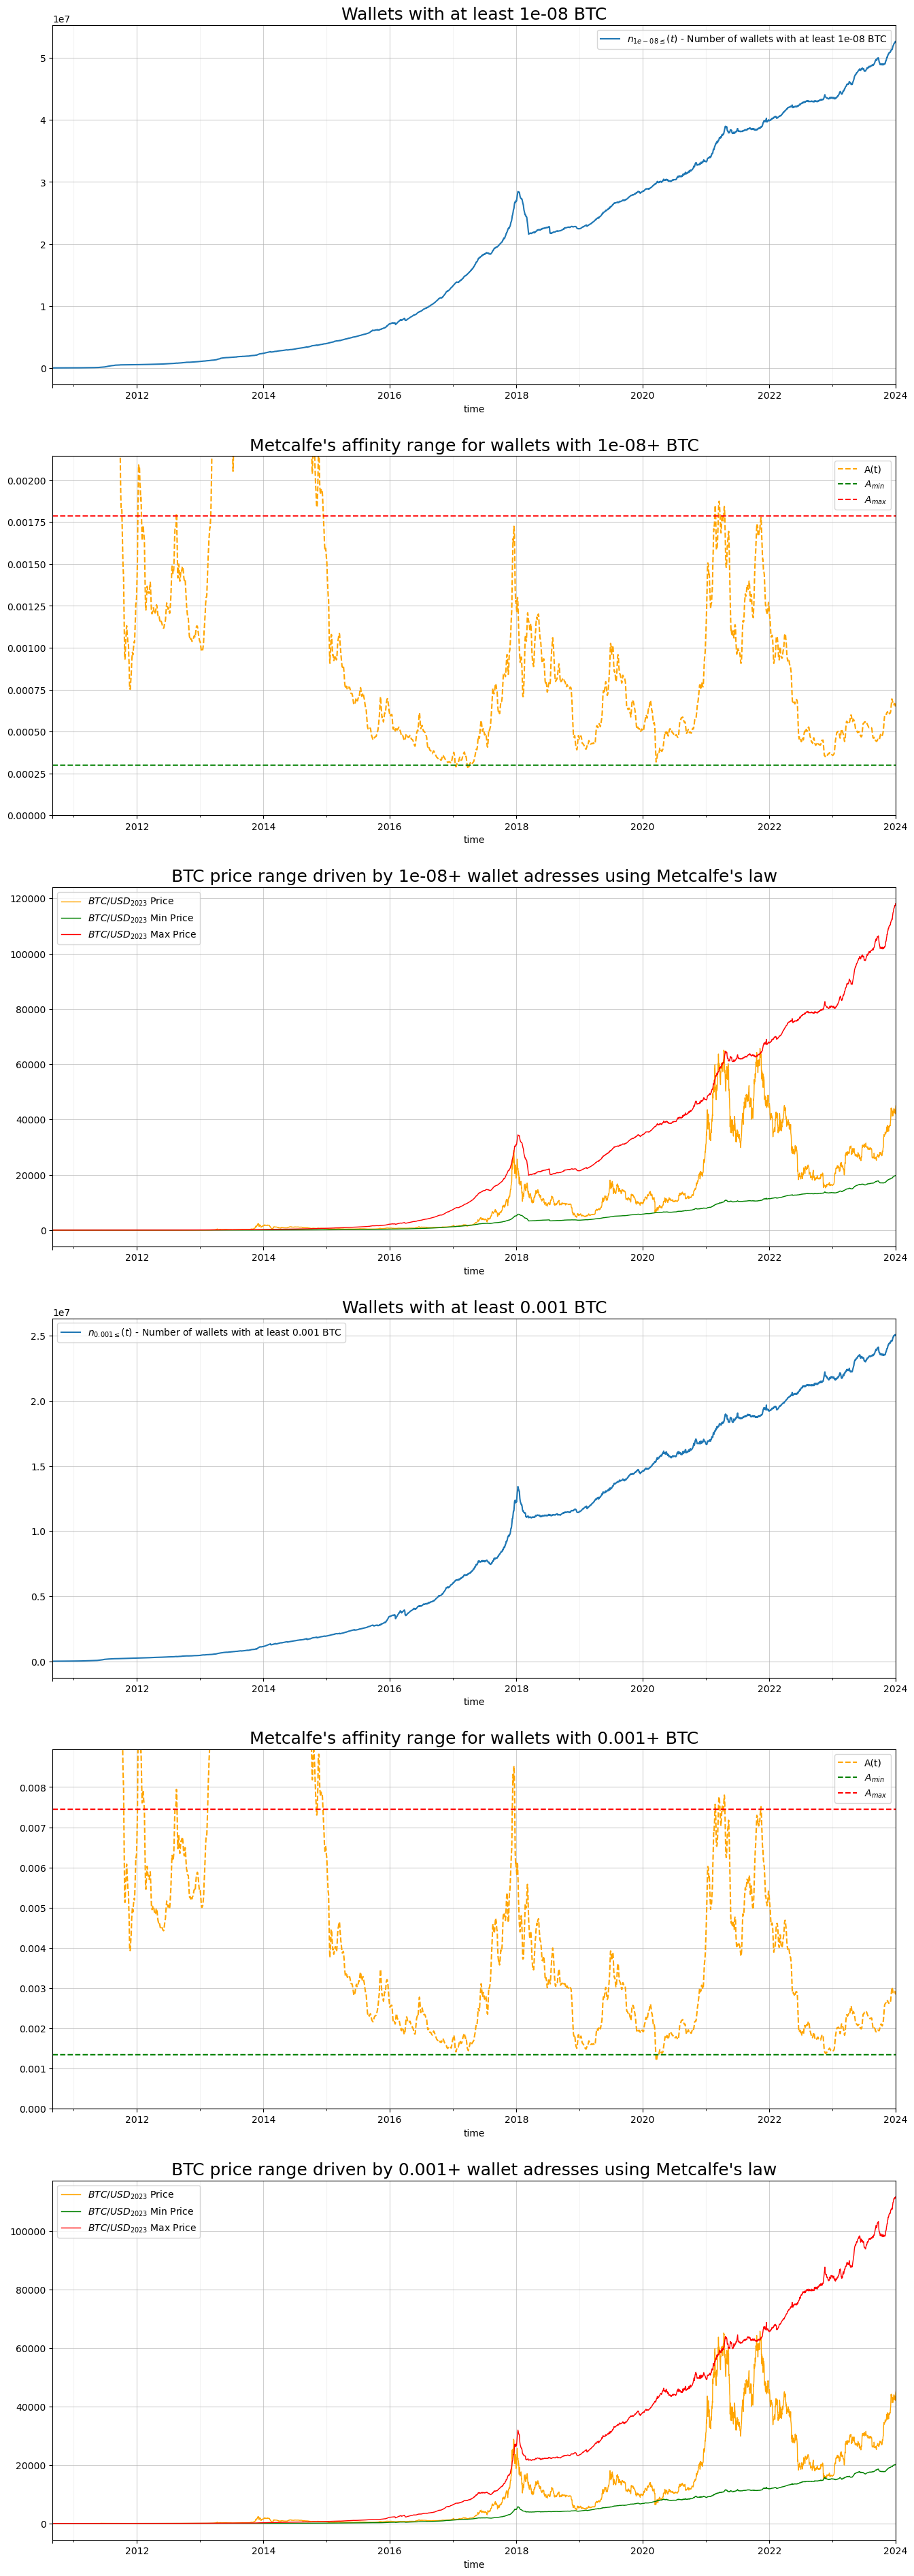

In [9]:
import matplotlib.pyplot as plt
today=df[df[coin]['USD']['price'] >0 ].index.max()
subplots = len(wallet_ranges)*3;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)

i=0
for wallet_range in wallet_ranges:
#for i in range(1,subplots,2) :
    min_btc = float(wallet_range[:-1]) 
    axs[i].set_title("Wallets with at least {} {}".format(min_btc, coin), fontsize=18)
    df[coin][wallet_range]['addresses'][plot_start_date:today].plot(ax=axs[i],label='$n_{{ {} \leq}}(t) $ - Number of wallets with at least {} {}'.format(min_btc, min_btc, coin) )
    axs[i].legend(loc='best')
    axs[i].grid(axis='both', which='major', alpha=0.6)
    axs[i].grid(axis='both', which='minor', alpha=0.15)  
    
 
    axs[i+1].set_title("Metcalfe's affinity range for wallets with {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['a_sma7d'][plot_start_date:today].plot(ax=axs[i+1],color='orange',label='A(t)', linestyle='dashed')
    (df[coin][wallet_range]['a_min'][plot_start_date:today]*btc_max_supply).plot(ax=axs[i+1],color='green',label='$A_{min}$', linestyle='dashed')
    (df[coin][wallet_range]['a_max'][plot_start_date:today]*btc_max_supply).plot(ax=axs[i+1],color='red',label='$A_{max}$', linestyle='dashed')
    axs[i+1].legend(loc='best')
    axs[i+1].grid(which='major', alpha=0.6)
    axs[i+1].grid(which='minor', alpha=0.15)
    axs[i+1].set_ylim([0,df[coin][wallet_range]['a_max'][plot_start_date:today].max()*1.2*btc_max_supply])

    axs[i+2].set_title("{} price range driven by {} wallet adresses using Metcalfe's law".format(coin, wallet_range), fontsize=18)

    m2_adj_='m2_adj_'
    #m2_adj_=''
    if 'm2_adj_'  == m2_adj_:
        m2_adj_text = "USD M2 Supply adjusted "
        m2_adj_text = str(usd_baseline_date.year) # + "-" + str(usd_baseline_date.month)
        
    else:
         m2_adj_text = ""
    df[coin][adj_usd_key]['price'][plot_start_date:today].plot(ax=axs[i+2], linewidth=1, color='orange',label='${}/USD_{{{}}}$ Price'.format(coin, m2_adj_text))
    df[coin][wallet_range]['price_min_' + adj_usd_key][plot_start_date:today].plot(ax=axs[i+2], linewidth=1,color='green',label='${}/USD_{{{}}}$ Min Price'.format(coin, m2_adj_text))
    df[coin][wallet_range]['price_max_' + adj_usd_key][plot_start_date:today].plot(ax=axs[i+2], linewidth=1,color='red',label='${}/USD_{{{}}}$ Max Price'.format(coin, m2_adj_text))
    #axs[i+1].set_yscale('log')
    axs[i+2].legend(loc='best')
    axs[i+2].grid(which='major', alpha=0.6)
    axs[i+2].grid(which='minor', alpha=0.15)     
    i=i+3

## Finding Wallet Growth Function

### Staging Data

In [10]:
extrapolation_end_date = extrapolation_end_date or '2034-01-01'

t_0 = pd.Timestamp('2015-01-01')
df.loc(axis=1)[(coin,'all','delta_days')] = (df.index-t_0).days
today=df[df[coin]['USD']['price'] >0 ].index.max()
min_date = df.index.min()
ix = pd.date_range(start=min_date, end=date.fromisoformat(extrapolation_end_date), freq='D')
df = df.reindex(ix)
df.loc(axis=1)[(coin,'all','delta_days')] = (df.index-t_0).days
df

coin           BTC                           USD                         BTC  \
wallet_range   USD    0.001+    1e-08+       all     USD_2023_11 USD_2023_11   
metrics      price addresses addresses m2_supply m2_supply_index       price   
2010-01-01     0.0   29959.0   29959.0    8464.4        0.407722         0.0   
2010-01-02     0.0   30085.0   30085.0    8464.4        0.407722         0.0   
2010-01-03     0.0   30271.0   30271.0    8464.4        0.407722         0.0   
2010-01-04     0.0   30372.0   30372.0    8464.4        0.407722         0.0   
2010-01-05     0.0   30570.0   30570.0    8464.4        0.407722         0.0   
...            ...       ...       ...       ...             ...         ...   
2033-12-28     NaN       NaN       NaN       NaN             NaN         NaN   
2033-12-29     NaN       NaN       NaN       NaN             NaN         NaN   
2033-12-30     NaN       NaN       NaN       NaN             NaN         NaN   
2033-12-31     NaN       NaN       NaN       NaN             NaN         NaN   
2034-01-01     NaN       NaN       NaN       NaN             NaN         NaN   

coin                                           ...                           \
wallet_range 1e-08+                            ...     0.001+        1e-08+   
metrics           a a_sma7d a_sma30d a_sma90d  ... a_sma1300d         a_min   
2010-01-01      0.0     NaN      NaN      NaN  ...        NaN  1.424951e-11   
2010-01-02      0.0     NaN      NaN      NaN  ...        NaN  1.424951e-11   
2010-01-03      0.0     NaN      NaN      NaN  ...        NaN  1.424951e-11   
2010-01-04      0.0     NaN      NaN      NaN  ...        NaN  1.424951e-11   
2010-01-05      0.0     NaN      NaN      NaN  ...        NaN  1.424951e-11   
...             ...     ...      ...      ...  ...        ...           ...   
2033-12-28      NaN     NaN      NaN      NaN  ...        NaN           NaN   
2033-12-29      NaN     NaN      NaN      NaN  ...        NaN           NaN   
2033-12-30      NaN     NaN      NaN      NaN  ...        NaN           NaN   
2033-12-31      NaN     NaN      NaN      NaN  ...        NaN           NaN   
2034-01-01      NaN     NaN      NaN      NaN  ...        NaN           NaN   

coin                                                                    \
wallet_range                                                             
metrics      price_min_USD_2023_11         a_max price_max_USD_2023_11   
2010-01-01                0.006395  8.508000e-11              0.038181   
2010-01-02                0.006449  8.508000e-11              0.038503   
2010-01-03                0.006529  8.508000e-11              0.038981   
2010-01-04                0.006572  8.508000e-11              0.039241   
2010-01-05                0.006658  8.508000e-11              0.039755   
...                            ...           ...                   ...   
2033-12-28                     NaN           NaN                   NaN   
2033-12-29                     NaN           NaN                   NaN   
2033-12-30                     NaN           NaN                   NaN   
2033-12-31                     NaN           NaN                   NaN   
2034-01-01                     NaN           NaN                   NaN   

coin                                                            \
wallet_range        0.001+                                       
metrics              a_min price_min_USD_2023_11         a_max   
2010-01-01    6.391041e-11              0.028681  3.546551e-10   
2010-01-02    6.391041e-11              0.028923  3.546551e-10   
2010-01-03    6.391041e-11              0.029282  3.546551e-10   
2010-01-04    6.391041e-11              0.029477  3.546551e-10   
2010-01-05    6.391041e-11              0.029863  3.546551e-10   
...                    ...                   ...           ...   
2033-12-28             NaN                   NaN           NaN   
2033-12-29             NaN                   NaN           NaN   
2033-12-3

### Fitting Wallet Growth to a Linear Function

$$
f(x) = bx+a
$$

In [11]:
import math
import numpy as np
from datetime import date

from scipy.optimize import curve_fit

def linear_function(n,a,b):
    return b*n+a

guess = [-3871929.863592148, 7147.744996880523]

for wallet_range in wallet_ranges:
    parameters, covariance = curve_fit(linear_function, df[coin]['all']['delta_days'][linear_fitting_start_date:today], df['BTC'][wallet_range]['addresses'][linear_fitting_start_date:today],p0=guess)
    # print("a={}, b={}".format(parameters[0],parameters[1]))
    df.loc(axis=1)[(coin,wallet_range,'addresses_linear_fit')]= linear_function((df.index-t_0).days,parameters[0],parameters[1])
    a_min = df[coin, wallet_range,'a_min'][today]
    a_max = df[coin, wallet_range,'a_max'][today]
    df.loc(axis=1)[(coin, wallet_range, 'price_min_linear_fit')] = \
        a_min/2 * df.loc(axis=1)[(coin,wallet_range,'addresses_linear_fit')]**2
    df.loc(axis=1)[(coin, wallet_range, 'price_max_linear_fit')] = \
        a_max/2 * df.loc(axis=1)[(coin,wallet_range,'addresses_linear_fit')]**2
    
df[coin]['0.001+']


metrics,addresses,a,a_sma7d,a_sma30d,a_sma90d,a_sma180d,a_sma365d,a_sma720d,a_sma1300d,a_min,price_min_USD_2023_11,a_max,price_max_USD_2023_11,addresses_linear_fit,price_min_linear_fit,price_max_linear_fit
2010-01-01,29959.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.391041e-11,0.028681,3.546551e-10,0.159159,-1.170680e+07,4379.432909,24302.584988
2010-01-02,30085.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.391041e-11,0.028923,3.546551e-10,0.160500,-1.169965e+07,4374.086475,24272.916267
2010-01-03,30271.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.391041e-11,0.029282,3.546551e-10,0.162491,-1.169250e+07,4368.743306,24243.265668
2010-01-04,30372.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.391041e-11,0.029477,3.546551e-10,0.163577,-1.168535e+07,4363.403403,24213.633189
2010-01-05,30570.0,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,6.391041e-11,0.029863,3.546551e-10,0.165717,-1.167821e+07,4358.066765,24184.018831
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2033-12-28,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.092435e+07,82869.080671,459861.566040
2033-12-29,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.093149e+07,82892.346291,459990.672872
2033-12-30,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.093864e+07,82915.615177,460119.797826
2033-12-31,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,5.094579e+07,82938.887328,460248.940900


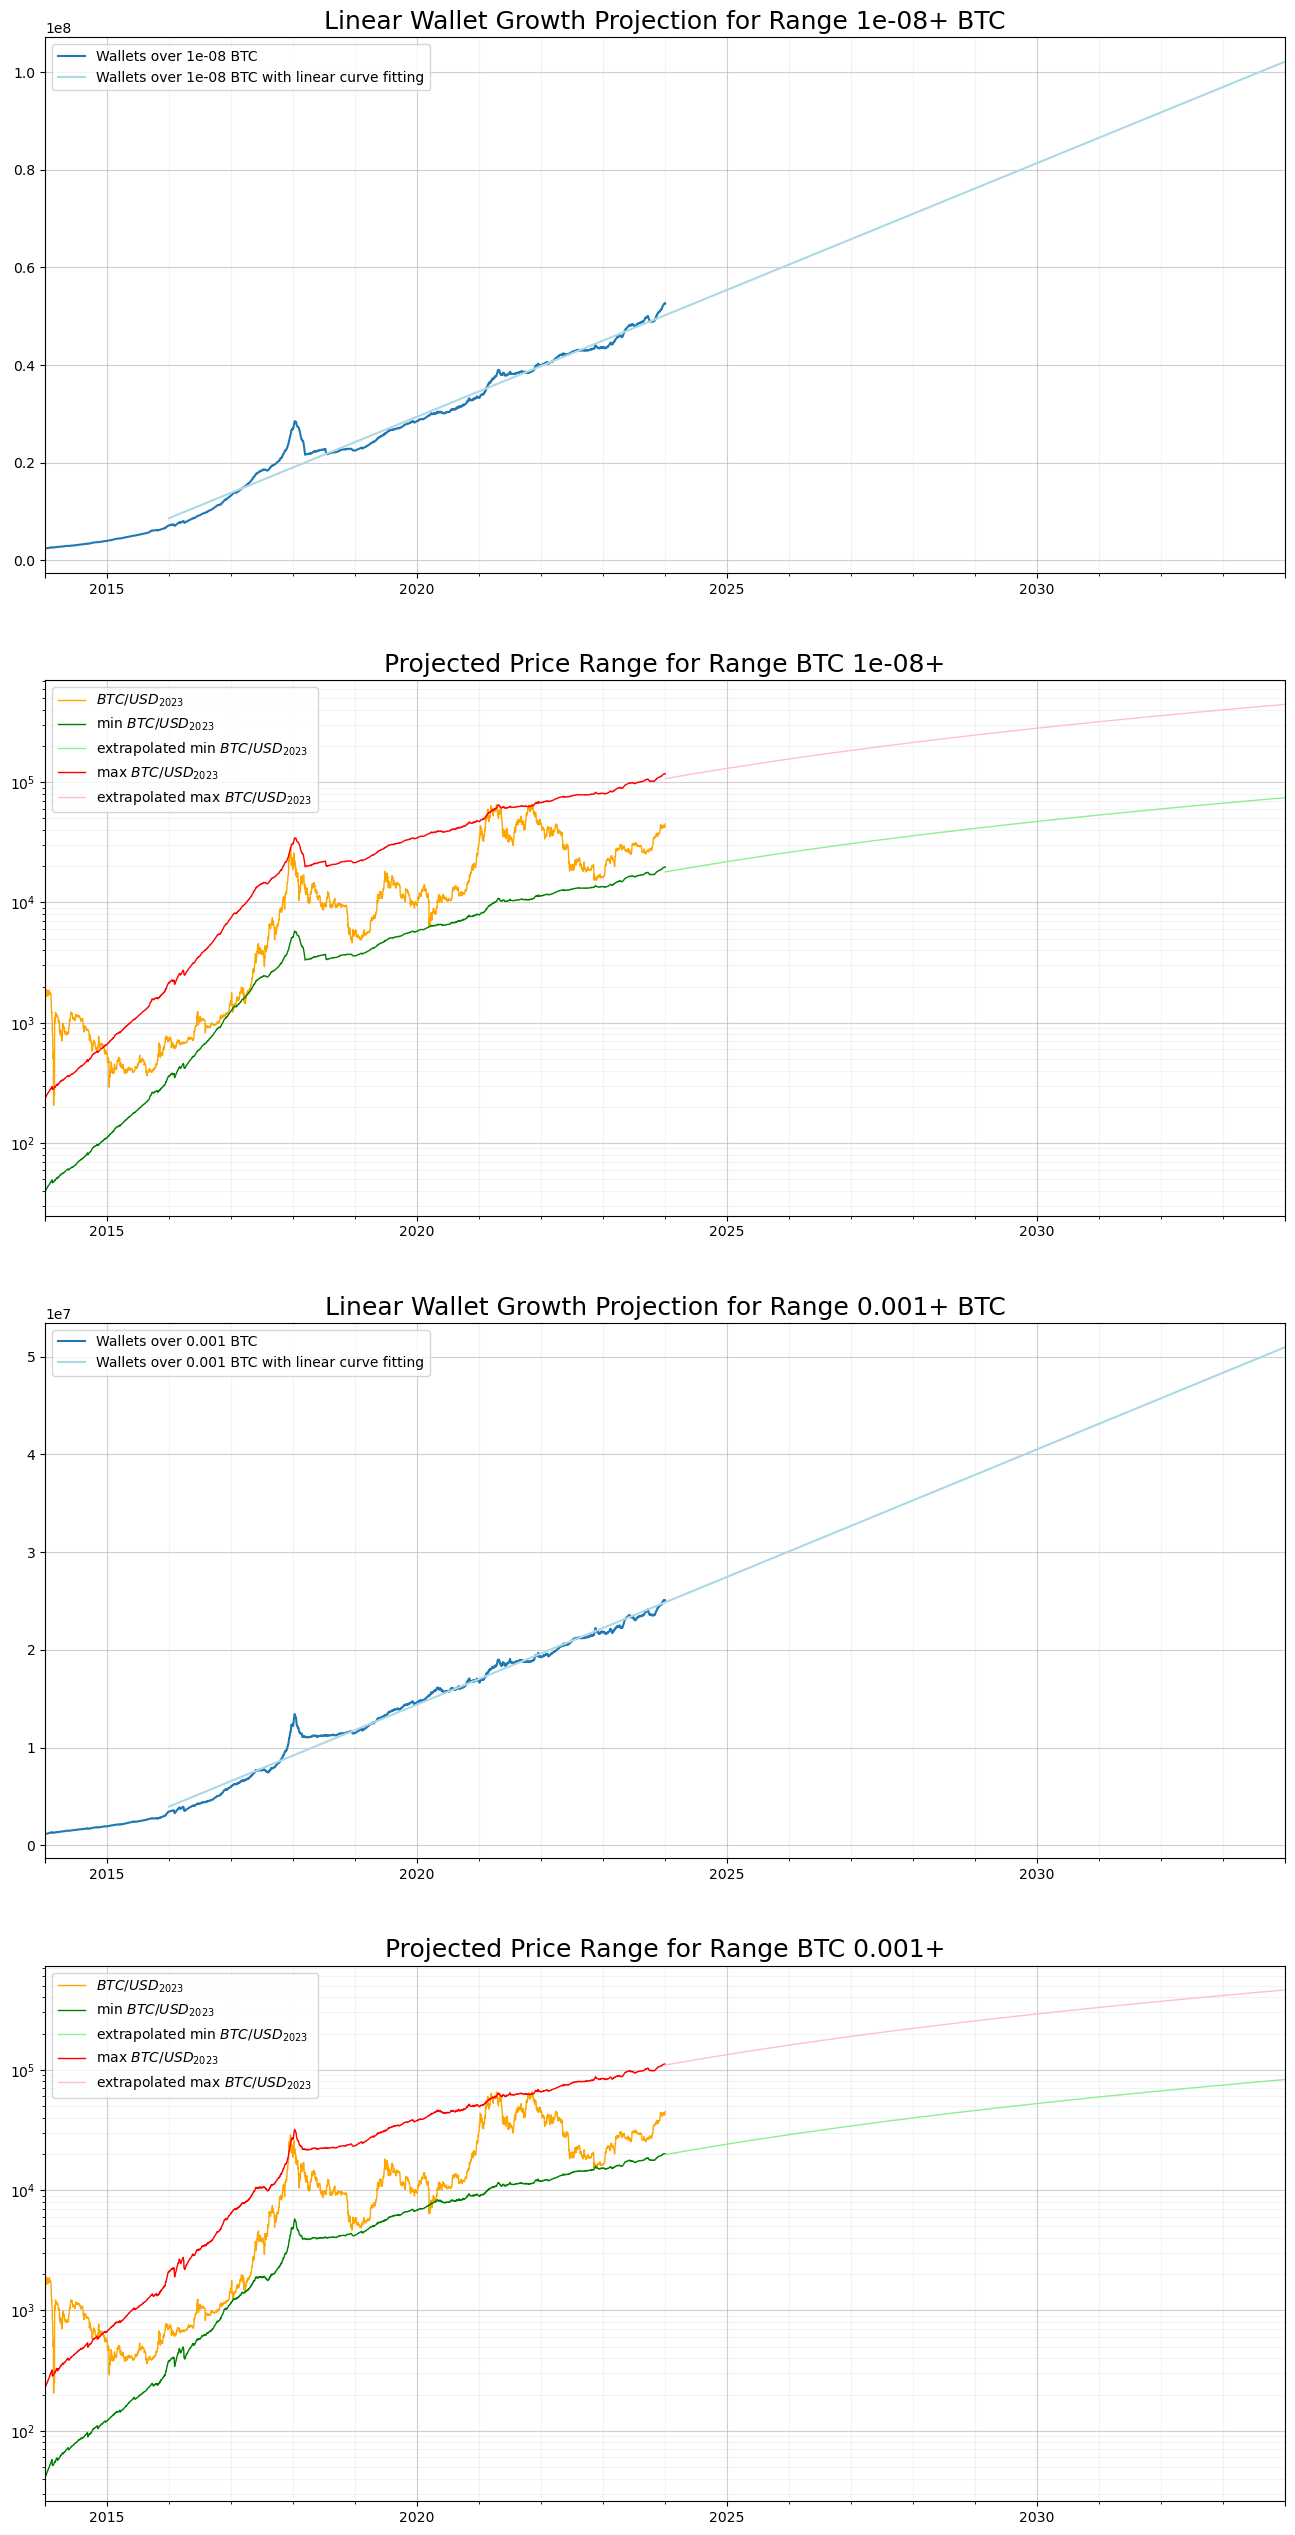

In [12]:
import matplotlib.pyplot as plt
subplots = len(wallet_ranges)*2;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)
i=0
for wallet_range in wallet_ranges:
    min_btc = wallet_range[:-1]
    #------------- axs[i]
    axs[i].set_title("Linear Wallet Growth Projection for Range {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['addresses'][plot_start_date_extrapolation:today].plot(ax=axs[i],label='Wallets over {} {}'.format(min_btc, coin) )
    df[coin][wallet_range]['addresses_linear_fit'][linear_fitting_start_date:].plot(ax=axs[i],label='Wallets over {} {} with linear curve fitting'.format(min_btc, coin), color='lightblue')
    axs[i].legend(loc='best')
    axs[i].grid(which='major', alpha=0.6)
    axs[i].grid(which='minor', alpha=0.15) 
    #------------- axs[i+1]
    axs[i+1].set_title("Projected Price Range for Range {} {}".format(coin, wallet_range), fontsize=18)

    df[coin][adj_usd_key]['price'][plot_start_date_extrapolation:].plot(ax=axs[i+1], linewidth=1, color='orange',label='${}/USD_{{{}}}$'.format(coin, m2_adj_text))
    df[coin][wallet_range]['price_min_' + adj_usd_key][plot_start_date_extrapolation:].plot(ax=axs[i+1], linewidth=1,color='green',label='min ${}/USD_{{{}}}$'.format(coin, m2_adj_text)) 
    df[coin][wallet_range]['price_min_linear_fit'][today:].plot(ax=axs[i+1], linewidth=1, color='lightgreen',label='extrapolated min ${}/USD_{{{}}}$'.format(coin, m2_adj_text))
    df[coin][wallet_range]['price_max_' + adj_usd_key][plot_start_date_extrapolation:].plot(ax=axs[i+1], linewidth=1,color='red',label='max ${}/USD_{{{}}}$'.format(coin, m2_adj_text)) 
    df[coin][wallet_range]['price_max_linear_fit'][today:].plot(ax=axs[i+1], linewidth=1, color='pink',label='extrapolated max ${}/USD_{{{}}}$'.format(coin, m2_adj_text))
    axs[i+1].set_yscale('log')
    axs[i+1].legend(loc='best')
    axs[i+1].grid(which='major', alpha=0.6)
    axs[i+1].grid(which='minor', alpha=0.15) 
    i=i+2

### Fitting Wallet Growth to a Logistic Function

[Logistic Curve](https://en.wikipedia.org/wiki/Logistic_function) fitting for BTC Netork Users

$$
f(x) = \frac{L}{1+e^{-k(x-x_0)}}
$$


In [13]:
import math
import numpy as np
from datetime import date

from scipy.optimize import curve_fit

def logistic_function(x,L,k,x0):
    return L/(1+math.e**(-k*(x-x0)))

guess = [10*1000*1000*1000, 1/765, 365*4]

for wallet_range in wallet_ranges:
    parameters, covariance = curve_fit(logistic_function, df[coin]['all']['delta_days'][:today].map(lambda x:float(x)), df[coin][wallet_range]['addresses'][:today],p0=guess)
    perr = np.sqrt(np.diag(covariance))
    print("L={}, k={} p0={} - standard deviation errors = {}".format(parameters[0],parameters[1], parameters[2], perr))
    df.loc(axis=1)[(coin,wallet_range,'addresses_logistic_fit')]= logistic_function((df.index-t_0).days,parameters[0],parameters[1],parameters[2])
    a_min = df[coin, wallet_range,'a_min'][today]
    a_max = df[coin, wallet_range,'a_max'][today]
    df.loc(axis=1)[(coin, wallet_range, 'price_min_logistic_fit')] = \
        a_min/2 * df.loc(axis=1)[(coin,wallet_range,'addresses_logistic_fit')]**2
    df.loc(axis=1)[(coin, wallet_range, 'price_max_logistic_fit')] = \
        a_max/2 * df.loc(axis=1)[(coin,wallet_range,'addresses_logistic_fit')]**2
    
#df[coin]['0.001+']


L=52761139.776788294, k=0.0013208827760586943 p0=1625.8216231891247 - standard deviation errors = [2.09940746e+05 7.81758066e-06 8.22529595e+00]
L=24626769.575060945, k=0.0014573989479711416 p0=1522.054535086037 - standard deviation errors = [6.17933393e+04 6.40989063e-06 5.00304322e+00]


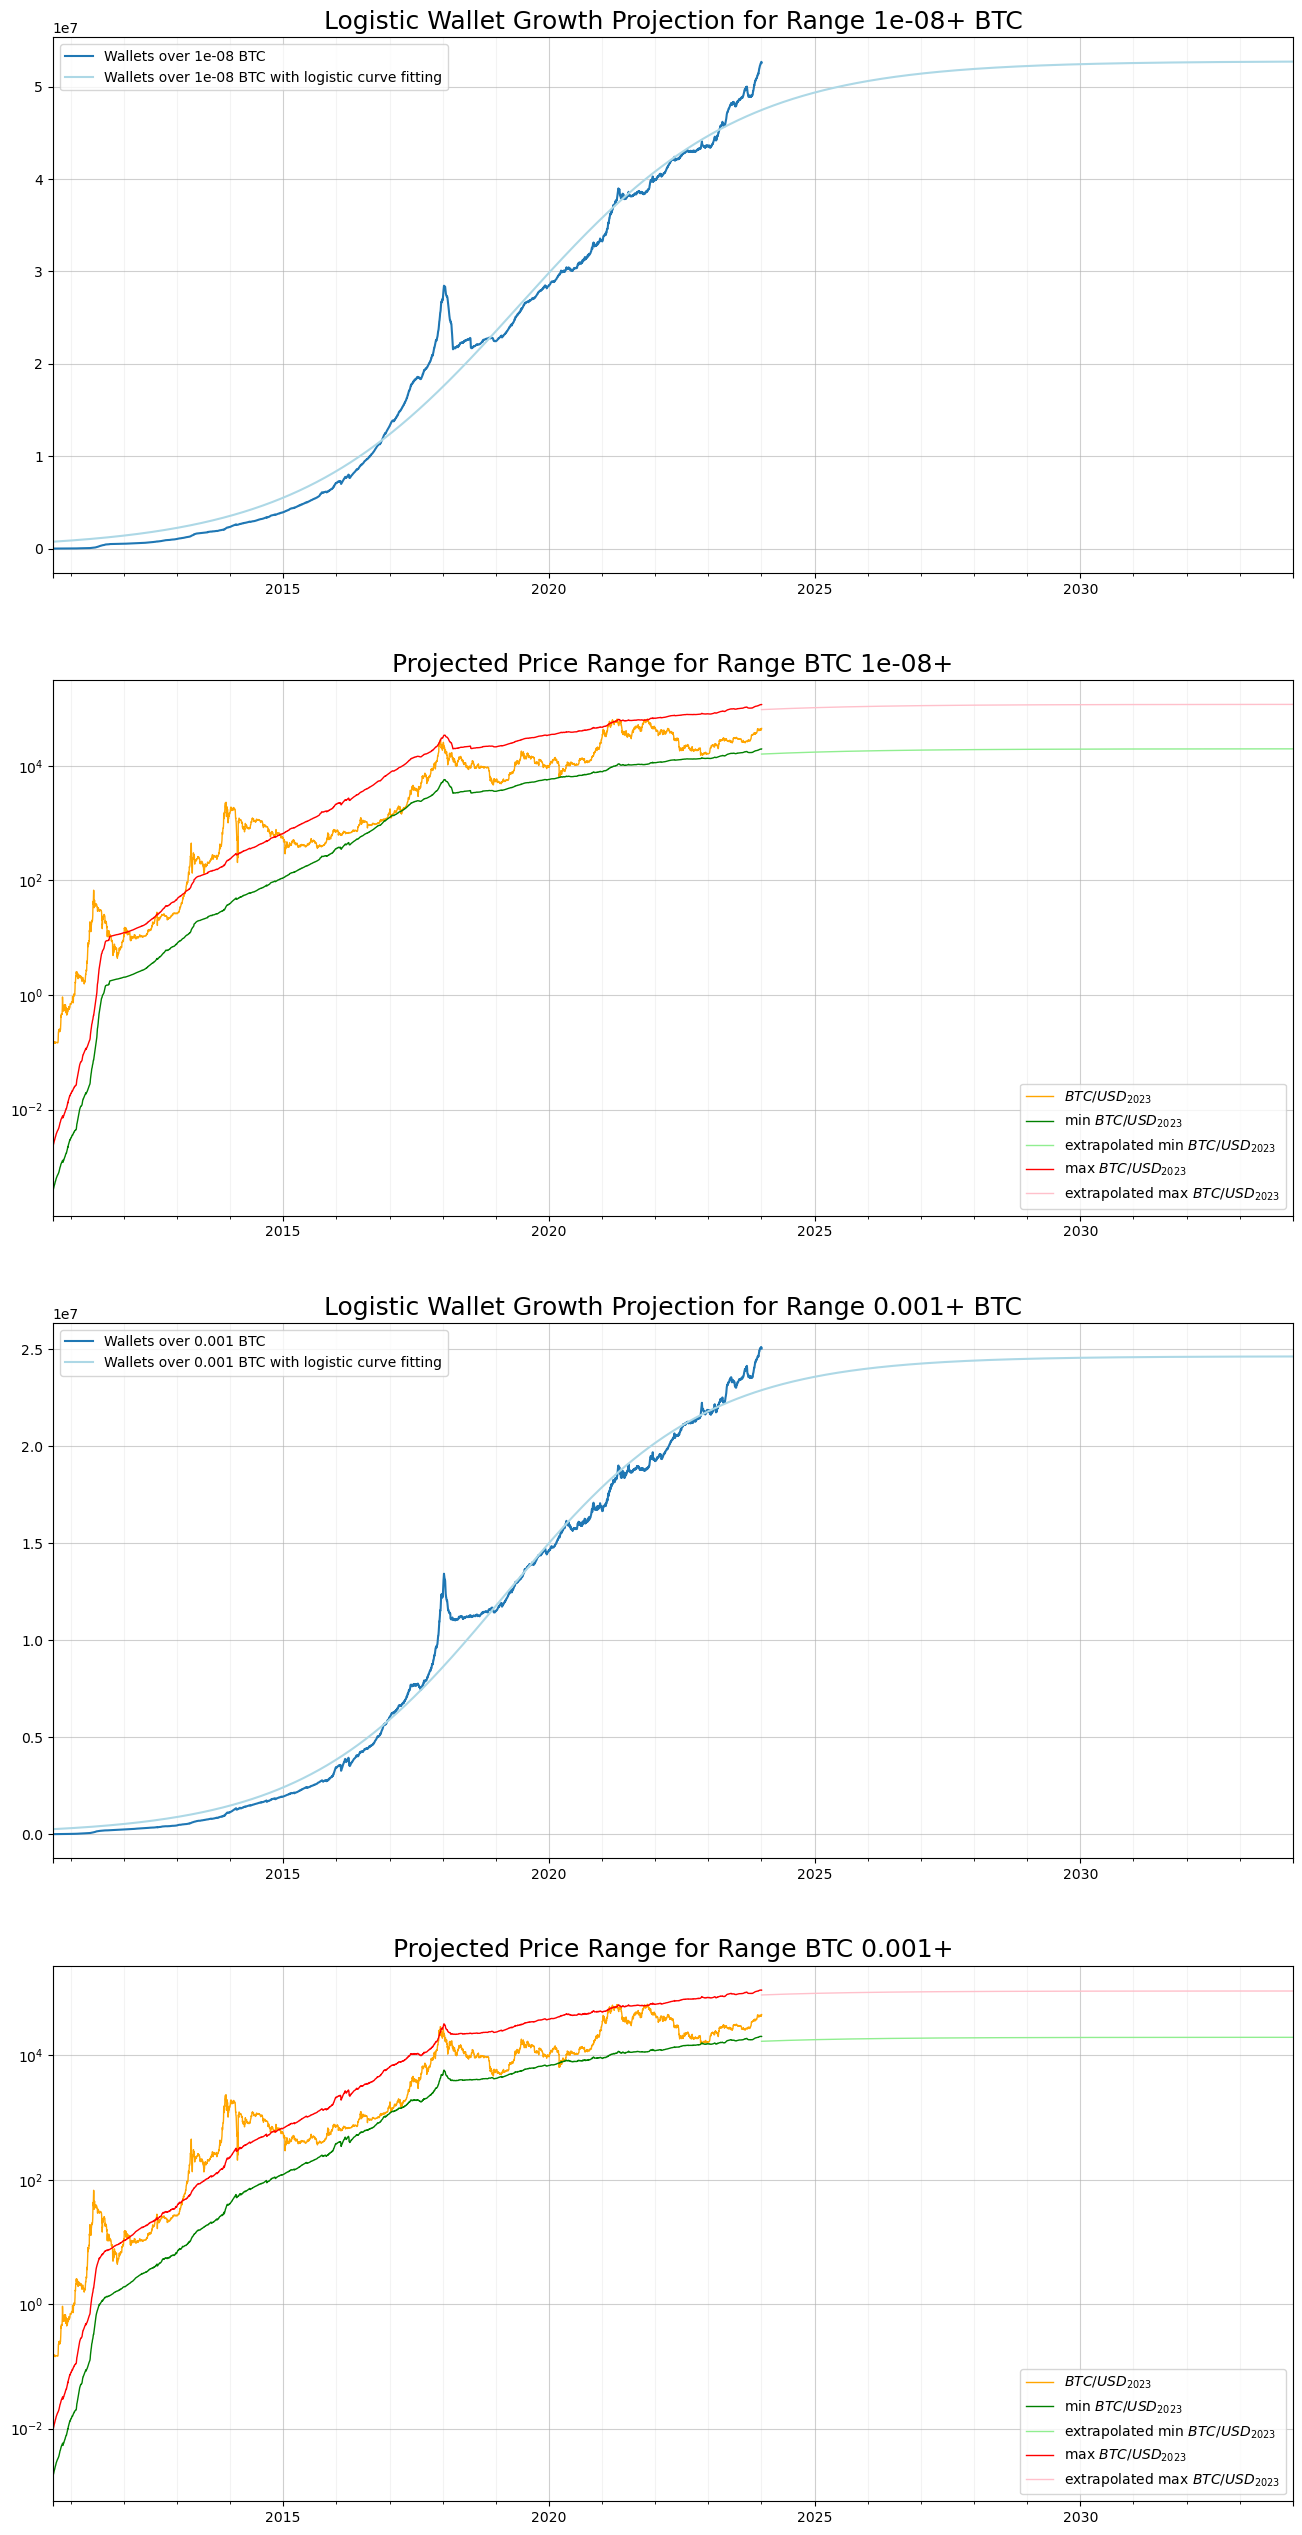

In [14]:
import matplotlib.pyplot as plt
subplots = len(wallet_ranges)*2;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)
i=0
for wallet_range in wallet_ranges:
    min_btc = wallet_range[:-1]
    #------------- axs[i]
    axs[i].set_title("Logistic Wallet Growth Projection for Range {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['addresses'][plot_start_date:today].plot(ax=axs[i],label='Wallets over {} {}'.format(min_btc, coin) )
    df[coin][wallet_range]['addresses_logistic_fit'][plot_start_date:].plot(ax=axs[i],label='Wallets over {} {} with logistic curve fitting'.format(min_btc, coin), color='lightblue')
    axs[i].legend(loc='best')
    axs[i].grid(which='major', alpha=0.6)
    axs[i].grid(which='minor', alpha=0.15) 
    #------------- axs[i+1]
    axs[i+1].set_title("Projected Price Range for Range {} {}".format(coin, wallet_range), fontsize=18)

    df[coin][adj_usd_key]['price'][plot_start_date:].plot(ax=axs[i+1], linewidth=1, color='orange',label='${}/USD_{{{}}}$'.format(coin, m2_adj_text))
    df[coin][wallet_range]['price_min_' + adj_usd_key][plot_start_date:].plot(ax=axs[i+1], linewidth=1,color='green',label='min ${}/USD_{{{}}}$'.format(coin, m2_adj_text)) 
    df[coin][wallet_range]['price_min_logistic_fit'][today:].plot(ax=axs[i+1], linewidth=1, color='lightgreen',label='extrapolated min ${}/USD_{{{}}}$'.format(coin, m2_adj_text))
    df[coin][wallet_range]['price_max_' + adj_usd_key][plot_start_date:].plot(ax=axs[i+1], linewidth=1,color='red',label='max ${}/USD_{{{}}}$'.format(coin, m2_adj_text)) 
    df[coin][wallet_range]['price_max_logistic_fit'][today:].plot(ax=axs[i+1], linewidth=1, color='pink',label='extrapolated max ${}/USD_{{{}}}$'.format(coin, m2_adj_text))
    axs[i+1].set_yscale('log')
    axs[i+1].legend(loc='best')
    axs[i+1].grid(which='major', alpha=0.6)
    axs[i+1].grid(which='minor', alpha=0.15) 
    i=i+2

### Fitting Wallet Growth to Gompertz Function

[Gompertz function](https://en.wikipedia.org/wiki/Gompertz_function)

$$
f(t) = ae^{-be^{t-t_0}}
$$



In [15]:
import math
import numpy as np
from datetime import date

from scipy.optimize import curve_fit

#def gompertz_function(x,a,b,c):
#    return a*math.e**(-b*math.e**(-c*x))

def gompertz_function(t, a, b, t_0):
    return a * np.exp(-np.exp(-b*(t-t_0)))
    
guess = [100*1000*1000, 0.0005, 365*6]

# The moving average of wallet growth that is used fitting the curve

tagen = 1300
for wallet_range in wallet_ranges:
    for days in smas: 
        df.loc(axis=1)[(coin, wallet_range, 'addresses_sma' + str(days) +'d')] = \
            df.loc(axis=1)[(coin, wallet_range,'addresses')].rolling(days).mean()
    # Fittibg Gompertz curve to the rollling average (sma) of wallet growth curve
    parameters, covariance =\
        curve_fit(gompertz_function, df[coin]['all']['delta_days'][min_date+pd.DateOffset(days=tagen):today],\
                  df[coin][wallet_range]['addresses_sma'+str(tagen) +'d'][min_date+pd.DateOffset(days=tagen):today], \
                  p0=guess, method='lm', check_finite = True, absolute_sigma= False)
    s = np.power(1.0*(df[coin]['all']['delta_days'][min_date+pd.DateOffset(days=tagen):today]+365*5),1.9)
    perr = np.sqrt(np.diag(covariance))
    print("Equal weigthed : a={} wallets, b={} t_0={}d={}y  - standard deviation errors = {}".format(int(parameters[0]), parameters[1], int(parameters[2]), parameters[2]/365, perr))
    df.loc(axis=1)[(coin,wallet_range,'addresses_gompertz_fit')]= \
        gompertz_function((df.index-t_0).days,parameters[0],parameters[1],parameters[2])

    # Fittibg Gompertz curve to the rollling average (sma) of wallet growth curve giving more weight to recent data 
    parameters_s, covariance_s =\
        curve_fit(gompertz_function, df[coin]['all']['delta_days'][min_date+pd.DateOffset(days=tagen):today], \
                  df[coin][wallet_range]['addresses_sma'+str(tagen) +'d'][min_date+pd.DateOffset(days=tagen):today], \
                  p0=guess, method='lm', check_finite = True, absolute_sigma= False, sigma= s)

    perr_s = np.sqrt(np.diag(covariance_s))
    print("Recent data more weighted: a={} wallets, b={} t_0={}d={}y  - standard deviation errors = {}".format(int(parameters_s[0]),parameters_s[1], int(parameters_s[2]), parameters_s[2]/365, perr_s))
    print("Sigma vector {} ".format(s))
    df.loc(axis=1)[(coin,wallet_range,'addresses_gompertz_fit_s')]= \
        gompertz_function((df.index-t_0).days,parameters_s[0],parameters_s[1],parameters_s[2])

    #df.loc(axis=1)[(coin,wallet_range,'addresses_gompertz_fit')]= gompertz_function((df.index-t_0).days,guess[0],guess[1],guess[2])

    a_min = df[coin, wallet_range,'a_min'][today]
    a_max = df[coin, wallet_range,'a_max'][today]
    df.loc(axis=1)[(coin, wallet_range, 'price_min_gompertz_fit')] = \
        a_min/2 * df.loc(axis=1)[(coin,wallet_range,'addresses_gompertz_fit')]**2
    df.loc(axis=1)[(coin, wallet_range, 'price_max_gompertz_fit')] = \
        a_max/2 * df.loc(axis=1)[(coin,wallet_range,'addresses_gompertz_fit')]**2
    
#df[coin]['0.001+']


Equal weigthed : a=58489004 wallets, b=0.0006955802356879466 t_0=1918d=5.256558039169745y  - standard deviation errors = [1.56831664e+05 2.00432422e-06 4.43758167e+00]
Recent data more weighted: a=64741837 wallets, b=0.0006356870562982104 t_0=2090d=5.726881735536728y  - standard deviation errors = [3.01208427e+05 2.08698301e-06 7.72196915e+00]
Sigma vector 2013-07-24    8.238675e+05
2013-07-25    8.250730e+05
2013-07-26    8.262793e+05
2013-07-27    8.274864e+05
2013-07-28    8.286944e+05
                  ...     
2023-12-29    1.111318e+07
2023-12-30    1.111731e+07
2023-12-31    1.112144e+07
2024-01-01    1.112558e+07
2024-01-02    1.112971e+07
Freq: D, Name: delta_days, Length: 3815, dtype: float64 
Equal weigthed : a=29195986 wallets, b=0.0007162226214902621 t_0=1946d=5.331708077488792y  - standard deviation errors = [5.80716502e+04 1.53748097e-06 3.20182105e+00]
Recent data more weighted: a=35558509 wallets, b=0.0006013975030272877 t_0=2279d=6.246292911318075y  - standard deviati

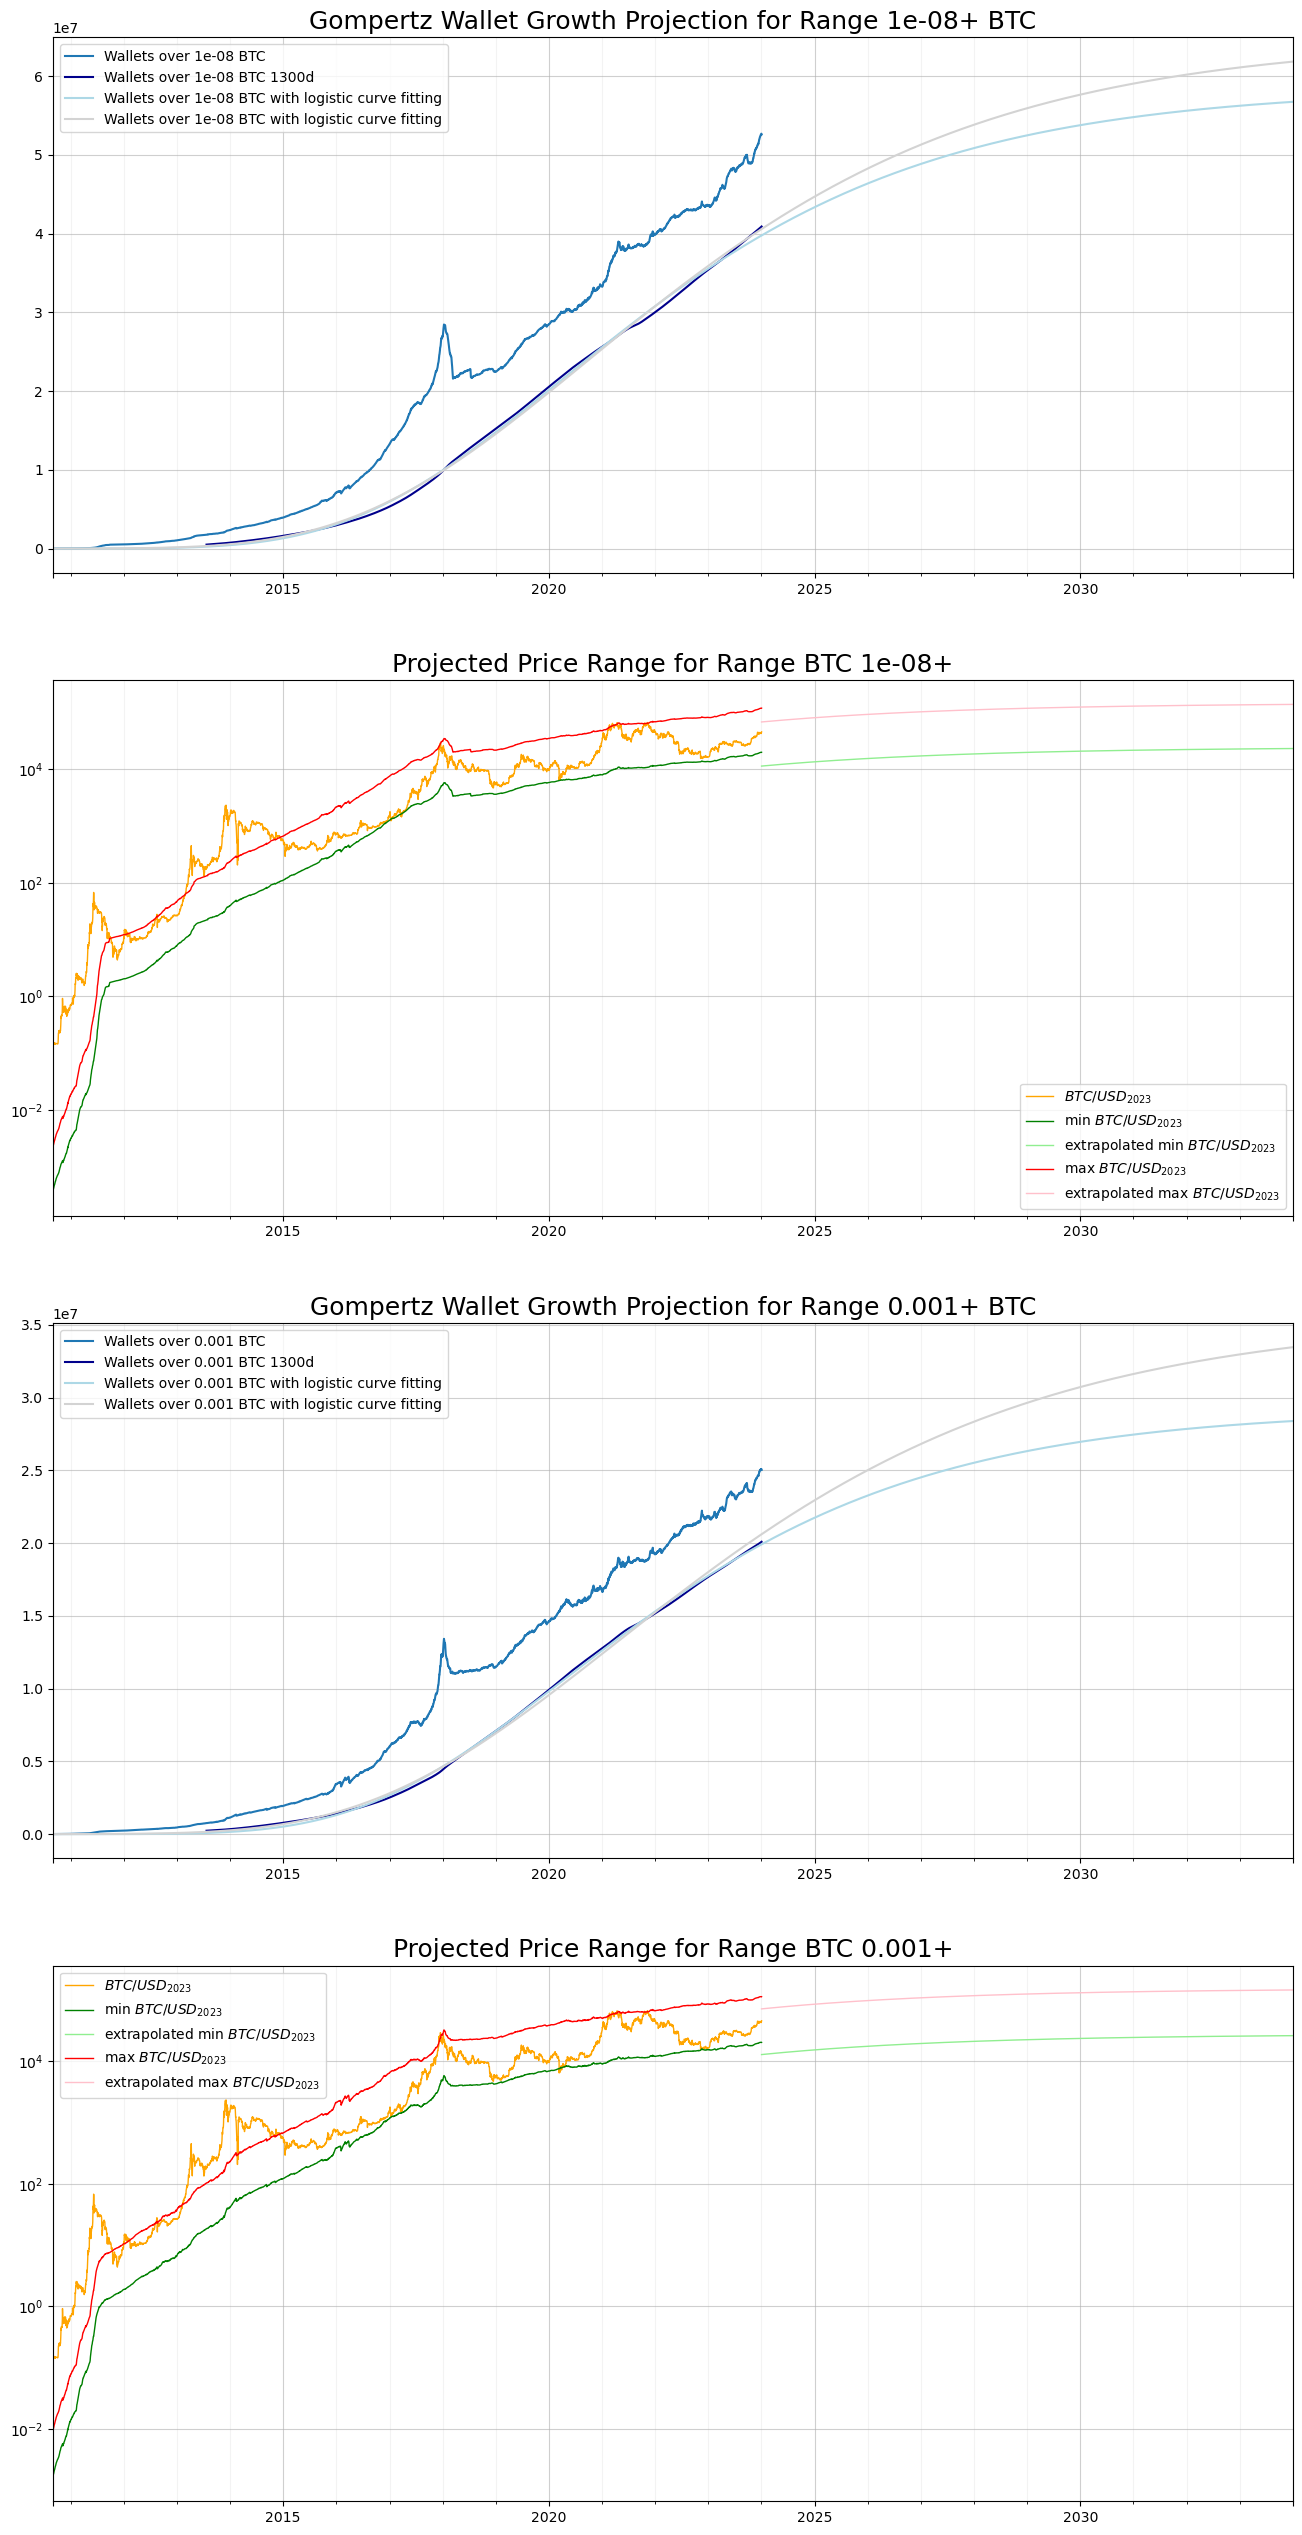

In [16]:
import matplotlib.pyplot as plt
subplots = len(wallet_ranges)*2;
fig, axs = plt.subplots(subplots)
fig.set_size_inches(16, 8*subplots)
i=0
for wallet_range in wallet_ranges:
    min_btc = wallet_range[:-1]
    #------------- axs[i]
    axs[i].set_title("Gompertz Wallet Growth Projection for Range {} {}".format(wallet_range, coin), fontsize=18)
    df[coin][wallet_range]['addresses'][plot_start_date:today].plot(ax=axs[i],label='Wallets over {} {}'.format(min_btc, coin) )
    df[coin][wallet_range]['addresses_sma'+ str(tagen) +'d'][plot_start_date:today].plot(ax=axs[i],label='Wallets over {} {} {}d'.format(min_btc, coin, tagen), color='darkblue' )
 
    df[coin][wallet_range]['addresses_gompertz_fit'][plot_start_date:].plot(ax=axs[i],label='Wallets over {} {} with logistic curve fitting'.format(min_btc, coin), color='lightblue')
    df[coin][wallet_range]['addresses_gompertz_fit_s'][plot_start_date:].plot(ax=axs[i],label='Wallets over {} {} with logistic curve fitting'.format(min_btc, coin), color='lightgrey')

    axs[i].legend(loc='best')
    #axs[i].set_yscale('log')
    axs[i].grid(which='major', alpha=0.6)
    axs[i].grid(which='minor', alpha=0.15) 

    #------------- axs[i+1]
    axs[i+1].set_title("Projected Price Range for Range {} {}".format(coin, wallet_range), fontsize=18)

    df[coin][adj_usd_key]['price'][plot_start_date:].plot(ax=axs[i+1], linewidth=1, color='orange',label='${}/USD_{{{}}}$'.format(coin, m2_adj_text))
    df[coin][wallet_range]['price_min_' + adj_usd_key][plot_start_date:].plot(ax=axs[i+1], linewidth=1,color='green',label='min ${}/USD_{{{}}}$'.format(coin, m2_adj_text)) 
    df[coin][wallet_range]['price_min_gompertz_fit'][today:].plot(ax=axs[i+1], linewidth=1, color='lightgreen',label='extrapolated min ${}/USD_{{{}}}$'.format(coin, m2_adj_text))
    df[coin][wallet_range]['price_max_' + adj_usd_key][plot_start_date:].plot(ax=axs[i+1], linewidth=1,color='red',label='max ${}/USD_{{{}}}$'.format(coin, m2_adj_text)) 
    df[coin][wallet_range]['price_max_gompertz_fit'][today:].plot(ax=axs[i+1], linewidth=1, color='pink',label='extrapolated max ${}/USD_{{{}}}$'.format(coin, m2_adj_text))
    axs[i+1].set_yscale('log')
    axs[i+1].legend(loc='best')
    axs[i+1].grid(which='major', alpha=0.6)
    axs[i+1].grid(which='minor', alpha=0.15) 
    i=i+2

## Appendix

In [17]:
#df.loc(axis=1)[('BTC_AdrBal1in10BCnt_func_unlimited')]=1000000
min_date = df.index.min()

def linear_growth_func(y_previous,a):
    return y_previous+a
def unlimited_growth_func(y_previous,r):
    return y_previous+r*y_previous
def logistic_growth_func(y_previous,r,M,m=1):
    return y_previous+y_previous*r*(1-(y_previous/M))**(1/m)

for wallet_range in wallet_ranges:
    initial_wallets =  df.loc(axis=1)[(coin,wallet_range,'addresses')][min_date]

    #wallet_range = str(min_btc) + '+'
    i = 0
    y_prev=initial_wallets
    for index, row in df.iterrows():
        y=logistic_growth_func(y_prev,1/450,50*1000*1000,1/4)
        df.loc[index,(coin, wallet_range, 'addresses_logistic_guess_A')] =y
        y_prev=y
        i=i+1
for wallet_range in wallet_ranges:
    initial_wallets =  df.loc(axis=1)[(coin,wallet_range,'addresses')][min_date]

    #wallet_range = str(min_btc) + '+'
    i = 0
    y_prev=initial_wallets
    for index, row in df.iterrows():
        y=logistic_growth_func(y_prev,1/450,100*1000*1000,1/9)
        df.loc[index,(coin, wallet_range, 'addresses_logistic_guess_B')] =y
        y_prev=y
        i=i+1    
for wallet_range in wallet_ranges:
    initial_wallets =  df.loc(axis=1)[(coin,wallet_range,'addresses')][min_date]

    #wallet_range = str(min_btc) + '+'
    i = 0
    y_prev=initial_wallets
    for index, row in df.iterrows():
        y=logistic_growth_func(y_prev,1/450,200*1000*1000,1/18)
        df.loc[index,(coin, wallet_range, 'addresses_logistic_guess_C')] =y
        y_prev=y
        i=i+1    
df= df.copy()
#df